In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import wandb
plt.style.use('seaborn')

<ipython-input-1-9a7a4ebfe912>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
def smooth(scalars, weight=0.1):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
        
    return smoothed

Text(0.5, 1.0, 'ABC123 vs $\\mathrm{ABC123}^{123}$')

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


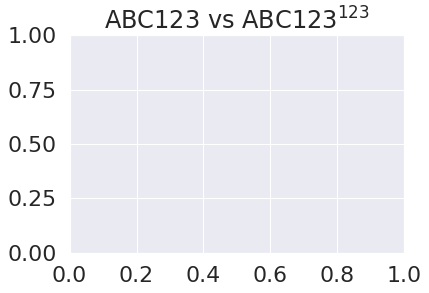

In [32]:
from matplotlib.ticker import FuncFormatter
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.0fM' % (x * 1e-6)
    '''
    if x < 1000000:
        return '%1.0fK' % (x * 1e-3)
    else:
        return '%1.0fM' % (x * 1e-6)
    '''
    #return '%1.0fK' % (x * 1e-3)


formatter = FuncFormatter(millions)

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')

In [33]:
def plot_mean_se(runs, l, c, ls, ax, lw=4, weight=0.1):
    xs = []
    ys = []
    for n, run in enumerate(runs):
        #if n == 0:
        #    continue
        if 'eval return' in run.history().keys():
            data = run.history(keys=['eval return', 'training steps'])
        else:
            data = run.history(keys=['eval/mean_reward', 'global_step'])
        #data = run.history(keys=['total post explore steps', 'training steps'])
        if n!= 5:
            if 'training steps' not in data:
                x = data['training steps'].tolist()
            else:
                x = data['training steps'].tolist()
            '''
            for n_x, single_x in enumerate(x):
                if single_x > 2000000:
                    x = x[:n_x]
                    break
            '''
            #y = data['total post explore steps'].tolist()
            if 'eval return' not in data:
                y = data['eval/mean_reward'].tolist()
            else:
                y = data['eval return'].tolist()
            #y = y[:n_x]
            xs.append(x)
            ys.append(y)
    # make sure they have the same len
    min_len = np.inf
    for n, y in enumerate(ys):
        if len(y) < min_len:
            min_len = len(y)
            min_idx = n
    new_ys = []
    for y in ys:
        new_ys.append(y[:min_len])
    ys = new_ys
    
    x = xs[min_idx]
    #x = x[:(min_len-1)]
    y_avg = np.mean(ys, axis=0)
    y_avg = smooth(y_avg, weight=weight)
    y_ste = np.std(ys, axis=0) / np.sqrt(len(ys))
    #for lava there are only 30 steps
    #x = x[:50]
    #y_avg = y_avg[:30]
    #y_ste = y_ste[:30]
    #plt.xscale('log')
    ax.plot(x, y_avg, label=l, color=c, ls=ls, linewidth=lw)
    ax.xaxis.set_major_formatter(formatter)
    plt.fill_between(x, y_avg-y_ste, y_avg+y_ste, alpha=0.1, color=c)

In [34]:
def plot_group(group_runs, legend=[], color=[], shape=[], lw=[], x_label="Environment Steps", y_label='Goal Reaching Rate', out_legend=False, in_legend=False, size=40, font_scale=5, weight=0.1, title=''):
    sns.set(font_scale=font_scale)
    if legend == []:
        raise ValueError('plz input legend')
    if color == []:
        raise ValueError('plz input legend')
    if shape == []:
        raise ValueError('plz input legend')
    #plt.figure(figsize=(20, 25))
    plt.rcParams.update({'font.size': size})
    
    fig, ax = plt.subplots()
    fig.set_figheight(8)
    fig.set_figwidth(6)
    for i, group in enumerate(group_runs):
        plot_mean_se(group, legend[i], color[i], shape[i], lw=lw[i], weight=weight, ax=ax)
    if out_legend:
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25),
                  fancybox=True, shadow=True, ncol=5)
    if in_legend:
        plt.legend()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

### Tabular WindyGrid

#### Eval Return

In [6]:
api = wandb.Api()
entity, project = "zhao666", "2Mtabular"  # set to your entity and project 
group = []

In [8]:
filters = {
            "config.env_name": 'StochWindyGridWorld-v0',
            "config.total_steps": 200000,
            "config.ec_start": 0
}
runs = api.runs(entity + "/" + project, filters=filters, per_page=300) 
print('Configs: {} \nTotal runs: {}'.format(runs.filters, runs.length))

Configs: {'config.env_name': 'StochWindyGridWorld-v0', 'config.total_steps': 200000, 'config.ec_start': 0} 
Total runs: 5


In [9]:
group.append(runs)

In [11]:
filters = {
            "config.env_name": 'StochWindyGridWorld-v0',
            "config.total_steps": 200000,
            "config.ec_start": 1
}
runs = api.runs(entity + "/" + project, filters=filters, per_page=300) 
print('Configs: {} \nTotal runs: {}'.format(runs.filters, runs.length))

Configs: {'config.env_name': 'StochWindyGridWorld-v0', 'config.total_steps': 200000, 'config.ec_start': 1} 
Total runs: 5


In [12]:
group.append(runs)

In [14]:
filters = {
            "config.env_name": 'StochWindyGridWorld-v0',
            "config.total_steps": 200000,
            "config.ec_start": 0.1,
            "config.ec_end": 0.1
}
runs = api.runs(entity + "/" + project, filters=filters, per_page=300) 
print('Configs: {} \nTotal runs: {}'.format(runs.filters, runs.length))

Configs: {'config.env_name': 'StochWindyGridWorld-v0', 'config.total_steps': 200000, 'config.ec_start': 0.1, 'config.ec_end': 0.1} 
Total runs: 5


In [15]:
group.append(runs)

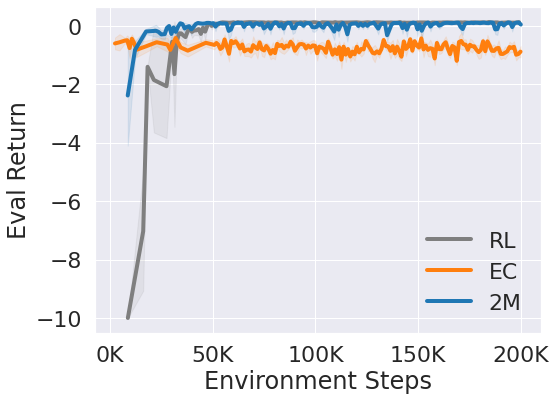

In [45]:
legend = ['RL', 'EC', '2M']
color = ['tab:grey', 'tab:orange', 'tab:blue']
shape = ['solid', 'solid', 'solid']
linewidth = [4, 4, 4]
plot_group(group, legend, color, shape, lw=linewidth, font_scale=2, weight=0.2, x_label='Environment Steps', y_label='Eval Return', title='', in_legend=True)

#### Q sum

In [46]:
def plot_mean_se(runs, l, c, ls, ax, lw, weight=0.1):
    xs = []
    ys = []
    for n, run in enumerate(runs):
        if 'rl Q sum' in run.history().keys():
            data = run.history(keys=['rl Q sum', 'training steps'])
        else:
            data = run.history(keys=['eval/mean_reward', 'global_step'])
        #data = run.history(keys=['total post explore steps', 'training steps'])
        if n!= 5:
            if 'training steps' not in data:
                x = data['global_step'].tolist()
            else:
                x = data['training steps'].tolist()
            #y = data['total post explore steps'].tolist()
            if 'rl Q sum' not in data:
                y = data['eval/mean_reward'].tolist()
            else:
                y = data['rl Q sum'].tolist()
            xs.append(x)
            ys.append(y)
    # make sure they have the same len
    min_len = np.inf
    for y in ys:
        if len(y) < min_len:
            min_len = len(y)
    new_ys = []
    for y in ys:
        new_ys.append(y[:(min_len-1)])
    ys = new_ys
    
    x = x[:(min_len-1)]
    y_avg = np.mean(ys, axis=0)
    y_avg = smooth(y_avg, weight=weight)
    y_ste = np.std(ys, axis=0) / np.sqrt(len(ys))
    #for lava there are only 30 steps
    #x = x[:50]
    #y_avg = y_avg[:30]
    #y_ste = y_ste[:30]
    ax.plot(x, y_avg, label=l, color=c, ls=ls, linewidth=4)
    ax.xaxis.set_major_formatter(formatter)
    plt.fill_between(x, y_avg-y_ste, y_avg+y_ste, alpha=0.1, color=c)

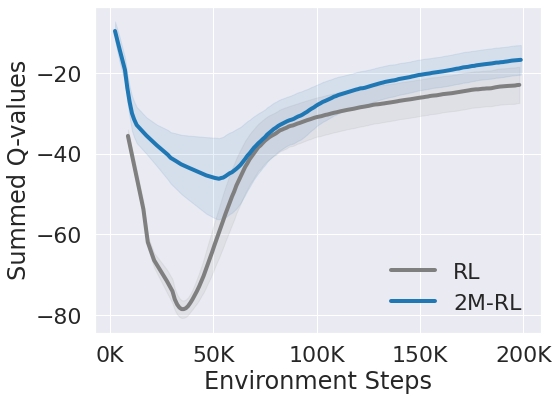

In [47]:
legend = ['RL', '2M-RL']
color = ['tab:grey', 'tab:blue']
shape = ['solid', 'solid']
plot_group(group[:2], legend, color, shape, lw=linewidth, font_scale=2, weight=0.1, x_label='Environment Steps', y_label='Summed Q-values', title='', in_legend=True)


### MinAtar

##### SpaceInvaders

In [6]:
api = wandb.Api()
entity, project = "zhao666", "2MMinAtarAllResults"  # set to your entity and project 
group = []

In [8]:
filters = {
            "config.env_name": 'MinAtar/SpaceInvaders-v1',
            "config.ec_factor_start": 1,
            "config.mfec_k": 3
}
runs = api.runs(entity + "/" + project, filters=filters, per_page=300) 
print('Configs: {} \nTotal runs: {}'.format(runs.filters, runs.length))

Configs: {'config.env_name': 'MinAtar/SpaceInvaders-v1', 'config.ec_factor_start': 1, 'config.mfec_k': 3} 
Total runs: 5


In [9]:
group.append(runs)

In [11]:
filters = {
            "config.env_name": 'MinAtar/SpaceInvaders-v1',
            "config.ec_factor_start": 0,
            "config.RL_train_freq": 10,
            "config.mfec_k": 3
}
runs = api.runs(entity + "/" + project, filters=filters, per_page=300) 
print('Configs: {} \nTotal runs: {}'.format(runs.filters, runs.length))

Configs: {'config.env_name': 'MinAtar/SpaceInvaders-v1', 'config.ec_factor_start': 0, 'config.RL_train_freq': 10, 'config.mfec_k': 3} 
Total runs: 5


In [12]:
group.append(runs)

In [13]:
api = wandb.Api()
entity, project = "zhao666", "2MAtariSto1SEEDwithSticky"  # set to your entity and project 

In [15]:
filters = {
            "config.env_name": 'MinAtar/SpaceInvaders-v1',
            "config.sticky_action_prob": 0.02,
            "config.rl_alg": 'emdqn'
}
runs = api.runs(entity + "/" + project, filters=filters, per_page=300) 
print('Configs: {} \nTotal runs: {}'.format(runs.filters, runs.length))

Configs: {'config.env_name': 'MinAtar/SpaceInvaders-v1', 'config.sticky_action_prob': 0.02, 'config.rl_alg': 'emdqn'} 
Total runs: 5


In [16]:
group.append(runs)

In [17]:
api = wandb.Api()
entity, project = "zhao666", "2MMinAtarAllResults"  # set to your entity and project 

In [19]:
filters = {
            "config.env_name": 'MinAtar/SpaceInvaders-v1',
            "config.ec_factor_start": 0.9,
            "config.ec_factor_end": 0.1,
            "config.mfec_k": 3,
            "config.data_sharing": False
}
runs = api.runs(entity + "/" + project, filters=filters, per_page=300) 
print('Configs: {} \nTotal runs: {}'.format(runs.filters, runs.length))

Configs: {'config.env_name': 'MinAtar/SpaceInvaders-v1', 'config.ec_factor_start': 0.9, 'config.ec_factor_end': 0.1, 'config.mfec_k': 3, 'config.data_sharing': False} 
Total runs: 5


In [20]:
group.append(runs)

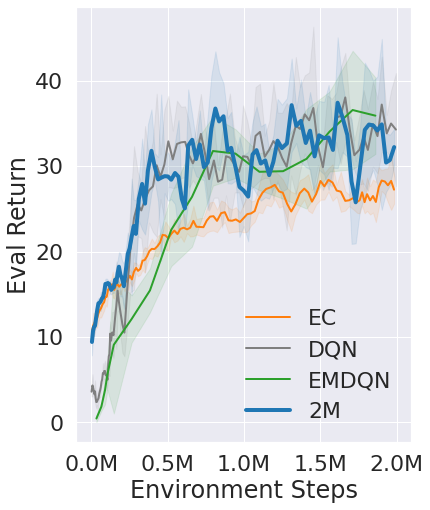

In [40]:
legend = ['EC', 'DQN', 'EMDQN', '2M']
color = ['tab:orange', 'tab:grey', 'tab:green', 'tab:blue']
shape = ['solid', 'solid', 'solid', 'solid']
linewidth = [2, 2, 2, 4]
plot_group(group, legend, color, shape, linewidth, font_scale=2, weight=0.6, x_label='Environment Steps', y_label='Eval Return', title='', in_legend=True)

##### Seaquest

In [41]:
api = wandb.Api()
entity, project = "zhao666", "2MMinAtarAllResults"  # set to your entity and project 
group = []

In [43]:
filters = {
            "config.env_name": 'MinAtar/Seaquest-v1',
            "config.ec_factor_start": 1,
            "config.RL_train_freq": 10,
            "config.mfec_k": 3
}
runs = api.runs(entity + "/" + project, filters=filters, per_page=300) 
print('Configs: {} \nTotal runs: {}'.format(runs.filters, runs.length))

Configs: {'config.env_name': 'MinAtar/Seaquest-v1', 'config.ec_factor_start': 1, 'config.RL_train_freq': 10, 'config.mfec_k': 3} 
Total runs: 5


In [44]:
group.append(runs)

In [46]:
filters = {
            "config.env_name": 'MinAtar/Seaquest-v1',
            "config.ec_factor_start": 0,
            "config.RL_train_freq": 10,
            "config.mfec_k": 3
}
runs = api.runs(entity + "/" + project, filters=filters, per_page=300) 
print('Configs: {} \nTotal runs: {}'.format(runs.filters, runs.length))

Configs: {'config.env_name': 'MinAtar/Seaquest-v1', 'config.ec_factor_start': 0, 'config.RL_train_freq': 10, 'config.mfec_k': 3} 
Total runs: 5


In [47]:
group.append(runs)

In [48]:
api = wandb.Api()
entity, project = "zhao666", "2MAtariSto1SEEDwithSticky"  # set to your entity and project 

In [50]:
filters = {
            "config.env_name": 'MinAtar/Seaquest-v1',
            "config.sticky_action_prob": 0.05,
            "config.rl_alg": 'emdqn'
}
runs = api.runs(entity + "/" + project, filters=filters, per_page=300) 
print('Configs: {} \nTotal runs: {}'.format(runs.filters, runs.length))

Configs: {'config.env_name': 'MinAtar/Seaquest-v1', 'config.sticky_action_prob': 0.05, 'config.rl_alg': 'emdqn'} 
Total runs: 5


In [51]:
group.append(runs)

In [52]:
api = wandb.Api()
entity, project = "zhao666", "2MMinAtarAllResults"  # set to your entity and project 

In [54]:
filters = {
            "config.env_name": 'MinAtar/Seaquest-v1',
            "config.ec_factor_start": 0.1,
            "config.ec_factor_end": 0.1,
            "config.mfec_k": 3,
            "config.data_sharing": True
}
runs = api.runs(entity + "/" + project, filters=filters, per_page=300) 
print('Configs: {} \nTotal runs: {}'.format(runs.filters, runs.length))

Configs: {'config.env_name': 'MinAtar/Seaquest-v1', 'config.ec_factor_start': 0.1, 'config.ec_factor_end': 0.1, 'config.mfec_k': 3, 'config.data_sharing': True} 
Total runs: 5


In [55]:
group.append(runs)

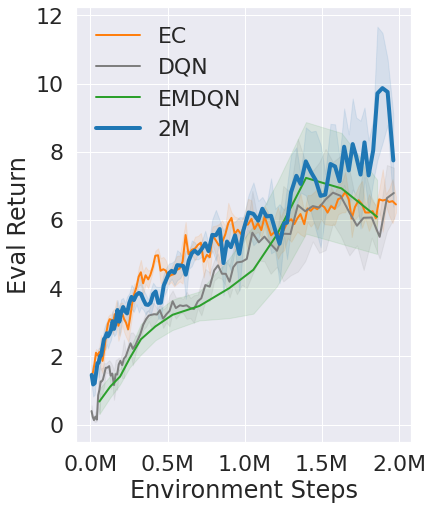

In [56]:
legend = ['EC', 'DQN', 'EMDQN', '2M']
color = ['tab:orange', 'tab:grey', 'tab:green', 'tab:blue']
shape = ['solid', 'solid', 'solid', 'solid']
linewidth = [2, 2, 2, 4]
plot_group(group, legend, color, shape, linewidth, font_scale=2, weight=0.5, x_label='Environment Steps', y_label='Eval Return', title='', in_legend=True)


##### Freeway

In [23]:
api = wandb.Api()
entity, project = "zhao666", "2MMinAtarAllResults"  # set to your entity and project 
group = []

In [25]:
filters = {
            "config.env_name": 'MinAtar/Freeway-v1',
            "config.ec_factor_start": 1,
            "config.RL_train_freq": 10,
            "config.sticky_action_prob": 0.01,
            "config.mfec_k": 3
}
runs = api.runs(entity + "/" + project, filters=filters, per_page=300) 
print('Configs: {} \nTotal runs: {}'.format(runs.filters, runs.length))

Configs: {'config.env_name': 'MinAtar/Freeway-v1', 'config.ec_factor_start': 1, 'config.RL_train_freq': 10, 'config.sticky_action_prob': 0.01, 'config.mfec_k': 3} 
Total runs: 5


In [26]:
group.append(runs)

In [28]:
filters = {
            "config.env_name": 'MinAtar/Freeway-v1',
            "config.ec_factor_start": 0,
            "config.RL_train_freq": 10,
            "config.sticky_action_prob": 0.01,
            "config.mfec_k": 3
}
runs = api.runs(entity + "/" + project, filters=filters, per_page=300) 
print('Configs: {} \nTotal runs: {}'.format(runs.filters, runs.length))

Configs: {'config.env_name': 'MinAtar/Freeway-v1', 'config.ec_factor_start': 0, 'config.RL_train_freq': 10, 'config.sticky_action_prob': 0.01, 'config.mfec_k': 3} 
Total runs: 5


In [29]:
group.append(runs)

In [30]:
api = wandb.Api()
entity, project = "zhao666", "2MAtariSto1SEEDwithSticky"  # set to your entity and project 

In [32]:
filters = {
            "config.env_name": 'MinAtar/Freeway-v1',
            "config.sticky_action_prob": 0.01,
            "config.rl_alg": 'emdqn'
}
runs = api.runs(entity + "/" + project, filters=filters, per_page=300) 
print('Configs: {} \nTotal runs: {}'.format(runs.filters, runs.length))

Configs: {'config.env_name': 'MinAtar/Freeway-v1', 'config.sticky_action_prob': 0.01, 'config.rl_alg': 'emdqn'} 
Total runs: 5


In [33]:
group.append(runs)

In [34]:
api = wandb.Api()
entity, project = "zhao666", "2MMinAtarAllResults"  # set to your entity and project 

In [36]:
filters = {
            "config.env_name": 'MinAtar/Freeway-v1',
            "config.ec_factor_start": 0.5,
            "config.ec_factor_end": 0.1,
            "config.mfec_k": 3,
            "config.data_sharing": True
}
runs = api.runs(entity + "/" + project, filters=filters, per_page=300) 
print('Configs: {} \nTotal runs: {}'.format(runs.filters, runs.length))

Configs: {'config.env_name': 'MinAtar/Freeway-v1', 'config.ec_factor_start': 0.5, 'config.ec_factor_end': 0.1, 'config.mfec_k': 3, 'config.data_sharing': True} 
Total runs: 5


In [37]:
group.append(runs)

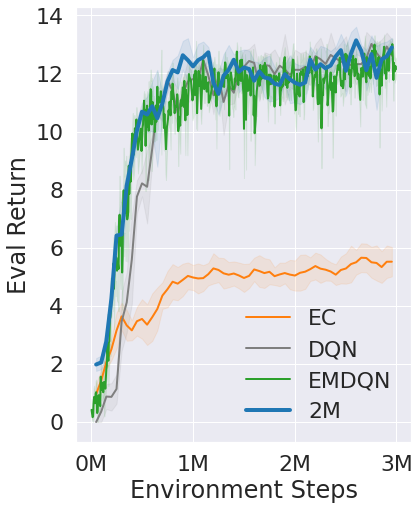

In [38]:
legend = ['EC', 'DQN', 'EMDQN', '2M']
color = ['tab:orange', 'tab:grey', 'tab:green',  'tab:blue']
shape = ['solid', 'solid', 'solid', 'solid']
linewidth = [2, 2, 2, 4]
plot_group(group, legend, color, shape, linewidth, font_scale=2, weight=0.4, x_label='Environment Steps', y_label='Eval Return', title='', in_legend=True)


##### Breakout

In [144]:
api = wandb.Api()
entity, project = "zhao666", "2MMinAtarAllResults"  # set to your entity and project 
group = []

In [146]:
filters = {
            "config.env_name": 'MinAtar/Breakout-v1',
            "config.ec_factor_start": 1,
            "config.RL_train_freq": 10,
            "config.mfec_k": 3
}
runs = api.runs(entity + "/" + project, filters=filters, per_page=300) 
print('Configs: {} \nTotal runs: {}'.format(runs.filters, runs.length))

Configs: {'config.env_name': 'MinAtar/Breakout-v1', 'config.ec_factor_start': 1, 'config.RL_train_freq': 10, 'config.mfec_k': 3} 
Total runs: 5


In [147]:
group.append(runs)

In [149]:
filters = {
            "config.env_name": 'MinAtar/Breakout-v1',
            "config.ec_factor_start": 0,
            "config.RL_train_freq": 10,
            "config.mfec_k": 3
}
runs = api.runs(entity + "/" + project, filters=filters, per_page=300) 
print('Configs: {} \nTotal runs: {}'.format(runs.filters, runs.length))

Configs: {'config.env_name': 'MinAtar/Breakout-v1', 'config.ec_factor_start': 0, 'config.RL_train_freq': 10, 'config.mfec_k': 3} 
Total runs: 5


In [150]:
group.append(runs)

In [151]:
api = wandb.Api()
entity, project = "zhao666", "2MAtariSto1SEEDwithSticky"  # set to your entity and project 

In [153]:
filters = {
            "config.env_name": 'MinAtar/Breakout-v1',
            "config.sticky_action_prob": 0.2,
            "config.rl_alg": 'emdqn'
}
runs = api.runs(entity + "/" + project, filters=filters, per_page=300) 
print('Configs: {} \nTotal runs: {}'.format(runs.filters, runs.length))

Configs: {'config.env_name': 'MinAtar/Breakout-v1', 'config.sticky_action_prob': 0.2, 'config.rl_alg': 'emdqn'} 
Total runs: 5


In [154]:
group.append(runs)

In [155]:
api = wandb.Api()
entity, project = "zhao666", "2MMinAtarAllResults"  # set to your entity and project 

In [157]:
filters = {
            "config.env_name": 'MinAtar/Breakout-v1',
            "config.ec_factor_start": 0.5,
            "config.ec_factor_end": 0.1,
            "config.mfec_k": 3,
            "config.data_sharing": True
}
runs = api.runs(entity + "/" + project, filters=filters, per_page=300) 
print('Configs: {} \nTotal runs: {}'.format(runs.filters, runs.length))

Configs: {'config.env_name': 'MinAtar/Breakout-v1', 'config.ec_factor_start': 0.5, 'config.ec_factor_end': 0.1, 'config.mfec_k': 3, 'config.data_sharing': True} 
Total runs: 5


In [158]:
group.append(runs)

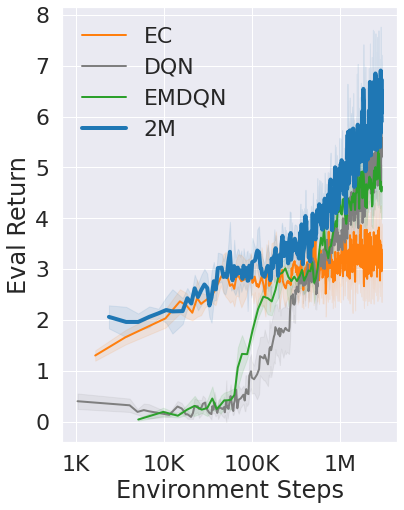

In [179]:
legend = ['EC', 'DQN', 'EMDQN', '2M']
color = ['tab:orange', 'tab:grey', 'tab:green', 'tab:blue']
shape = ['solid', 'solid', 'solid', 'solid']
linewidth = [2, 2, 2, 4]
plot_group(group, legend, color, shape, linewidth, font_scale=2, weight=0.5, x_label='Environment Steps', y_label='Eval Return', title='', in_legend=True)


##### Asterix

In [241]:
api = wandb.Api()
entity, project = "zhao666", "2MMinAtarAllResults"  # set to your entity and project 
group = []

In [243]:
filters = {
            "config.env_name": 'MinAtar/Asterix-v1',
            "config.ec_factor_start": 1,
            "config.RL_train_freq": 10,
            "config.mfec_k": 3
}
runs = api.runs(entity + "/" + project, filters=filters, per_page=300) 
print('Configs: {} \nTotal runs: {}'.format(runs.filters, runs.length))

Configs: {'config.env_name': 'MinAtar/Asterix-v1', 'config.ec_factor_start': 1, 'config.RL_train_freq': 10, 'config.mfec_k': 3} 
Total runs: 5


In [244]:
group.append(runs)

In [246]:
filters = {
            "config.env_name": 'MinAtar/Asterix-v1',
            "config.ec_factor_start": 0,
            "config.RL_train_freq": 10,
            "config.mfec_k": 3
}
runs = api.runs(entity + "/" + project, filters=filters, per_page=300) 
print('Configs: {} \nTotal runs: {}'.format(runs.filters, runs.length))

Configs: {'config.env_name': 'MinAtar/Asterix-v1', 'config.ec_factor_start': 0, 'config.RL_train_freq': 10, 'config.mfec_k': 3} 
Total runs: 5


In [247]:
group.append(runs)

In [248]:
api = wandb.Api()
entity, project = "zhao666", "2MAtariSto1SEEDwithSticky"  # set to your entity and project 

In [250]:
filters = {
            "config.env_name": 'MinAtar/Asterix-v1',
            "config.sticky_action_prob": 0.1,
            "config.rl_alg": 'emdqn'
}
runs = api.runs(entity + "/" + project, filters=filters, per_page=300) 
print('Configs: {} \nTotal runs: {}'.format(runs.filters, runs.length))

Configs: {'config.env_name': 'MinAtar/Asterix-v1', 'config.sticky_action_prob': 0.1, 'config.rl_alg': 'emdqn'} 
Total runs: 5


In [251]:
group.append(runs)

In [252]:
api = wandb.Api()
entity, project = "zhao666", "2MMinAtarAllResults"  # set to your entity and project 

In [254]:
filters = {
            "config.env_name": 'MinAtar/Asterix-v1',
            "config.ec_factor_start": 0.9,
            "config.ec_factor_end": 0.1,
            "config.RL_train_freq": 10,
            "config.mfec_k": 3,
            "config.data_sharing": False
}
runs = api.runs(entity + "/" + project, filters=filters, per_page=300) 
print('Configs: {} \nTotal runs: {}'.format(runs.filters, runs.length))

Configs: {'config.env_name': 'MinAtar/Asterix-v1', 'config.ec_factor_start': 0.9, 'config.ec_factor_end': 0.1, 'config.RL_train_freq': 10, 'config.mfec_k': 3, 'config.data_sharing': False} 
Total runs: 5


In [255]:
group.append(runs)

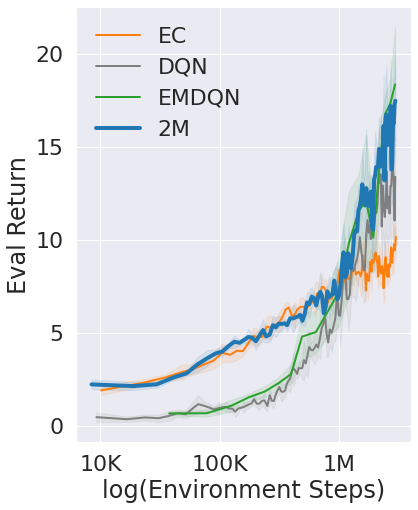

In [256]:
legend = ['EC', 'DQN', 'EMDQN', '2M']
color = ['tab:orange', 'tab:grey', 'tab:green', 'tab:blue']
shape = ['solid', 'solid', 'solid', 'solid']
linewidth = [2, 2, 2, 4]
plot_group(group, legend, color, shape, linewidth, font_scale=2, weight=0.5, x_label='log(Environment Steps)', y_label='Eval Return', title='', in_legend=True)


### Ablation study: ec factor start from ...

#### Breakout

In [96]:
api = wandb.Api()
entity, project = "zhao666", "2MMinAtarAllResults"  # set to your entity and project 
group = []

In [98]:
filters = {
            "config.env_name": 'MinAtar/Breakout-v1',
            "config.ec_factor_start": 0.1,
            "config.ec_factor_end": 0.9,
            "config.RL_train_freq": 10,
            "config.mfec_k": 3,
            "config.data_sharing": True
}
runs = api.runs(entity + "/" + project, filters=filters, per_page=300) 
print('Configs: {} \nTotal runs: {}'.format(runs.filters, runs.length))

Configs: {'config.env_name': 'MinAtar/Breakout-v1', 'config.ec_factor_start': 0.1, 'config.ec_factor_end': 0.9, 'config.RL_train_freq': 10, 'config.mfec_k': 3, 'config.data_sharing': True} 
Total runs: 5


In [99]:
group.append(runs)

In [101]:
filters = {
            "config.env_name": 'MinAtar/Breakout-v1',
            "config.ec_factor_start": 0.9,
            "config.ec_factor_end": 0.1,
            "config.RL_train_freq": 10,
            "config.mfec_k": 3,
            "config.data_sharing": True
}
runs = api.runs(entity + "/" + project, filters=filters, per_page=300) 
print('Configs: {} \nTotal runs: {}'.format(runs.filters, runs.length))

Configs: {'config.env_name': 'MinAtar/Breakout-v1', 'config.ec_factor_start': 0.9, 'config.ec_factor_end': 0.1, 'config.RL_train_freq': 10, 'config.mfec_k': 3, 'config.data_sharing': True} 
Total runs: 5


In [102]:
group.append(runs)

In [104]:
filters = {
            "config.env_name": 'MinAtar/Breakout-v1',
            "config.ec_factor_start": 0.5,
            "config.ec_factor_end": 0.5,
            "config.RL_train_freq": 10,
            "config.mfec_k": 3,
            "config.data_sharing": True
}
runs = api.runs(entity + "/" + project, filters=filters, per_page=300) 
print('Configs: {} \nTotal runs: {}'.format(runs.filters, runs.length))

Configs: {'config.env_name': 'MinAtar/Breakout-v1', 'config.ec_factor_start': 0.5, 'config.ec_factor_end': 0.5, 'config.RL_train_freq': 10, 'config.mfec_k': 3, 'config.data_sharing': True} 
Total runs: 5


In [105]:
group.append(runs)

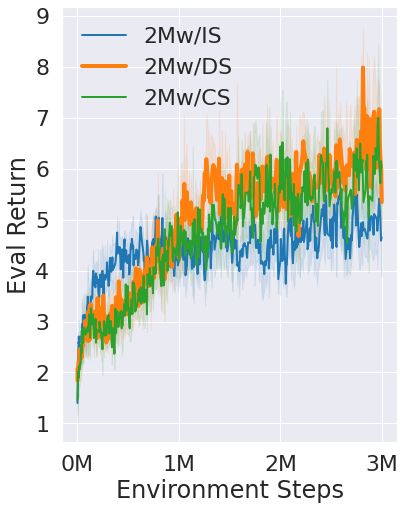

In [106]:
legend = ['2Mw/IS', '2Mw/DS', '2Mw/CS']
color = ['tab:blue', 'tab:orange', 'tab:green']
shape = ['solid', 'solid', 'solid', 'solid']
linewidth = [2, 4, 2]
plot_group(group, legend, color, shape, linewidth, font_scale=2, weight=0.5, x_label='Environment Steps', y_label='Eval Return', title='', in_legend=True)

#### SpaceInvaders

In [113]:
api = wandb.Api()
entity, project = "zhao666", "2MMinAtarAllResults"  # set to your entity and project 
group = []

In [115]:
filters = {
            "config.env_name": 'MinAtar/SpaceInvaders-v1',
            "config.ec_factor_start": 0.1,
            "config.ec_factor_end": 0.9,
            "config.RL_train_freq": 10,
            "config.mfec_k": 3,
            "config.data_sharing": False
}
runs = api.runs(entity + "/" + project, filters=filters, per_page=300) 
print('Configs: {} \nTotal runs: {}'.format(runs.filters, runs.length))

Configs: {'config.env_name': 'MinAtar/SpaceInvaders-v1', 'config.ec_factor_start': 0.1, 'config.ec_factor_end': 0.9, 'config.RL_train_freq': 10, 'config.mfec_k': 3, 'config.data_sharing': False} 
Total runs: 5


In [116]:
group.append(runs)

In [118]:
filters = {
            "config.env_name": 'MinAtar/SpaceInvaders-v1',
            "config.ec_factor_start": 0.9,
            "config.ec_factor_end": 0.1,
            "config.RL_train_freq": 10,
            "config.mfec_k": 3,
            "config.data_sharing": False
}
runs = api.runs(entity + "/" + project, filters=filters, per_page=300) 
print('Configs: {} \nTotal runs: {}'.format(runs.filters, runs.length))

Configs: {'config.env_name': 'MinAtar/SpaceInvaders-v1', 'config.ec_factor_start': 0.9, 'config.ec_factor_end': 0.1, 'config.RL_train_freq': 10, 'config.mfec_k': 3, 'config.data_sharing': False} 
Total runs: 5


In [119]:
group.append(runs)

In [121]:
filters = {
            "config.env_name": 'MinAtar/SpaceInvaders-v1',
            "config.ec_factor_start": 0.5,
            "config.ec_factor_end": 0.5,
            "config.RL_train_freq": 10,
            "config.mfec_k": 3,
            "config.data_sharing": False
}
runs = api.runs(entity + "/" + project, filters=filters, per_page=300) 
print('Configs: {} \nTotal runs: {}'.format(runs.filters, runs.length))

Configs: {'config.env_name': 'MinAtar/SpaceInvaders-v1', 'config.ec_factor_start': 0.5, 'config.ec_factor_end': 0.5, 'config.RL_train_freq': 10, 'config.mfec_k': 3, 'config.data_sharing': False} 
Total runs: 5


In [122]:
group.append(runs)

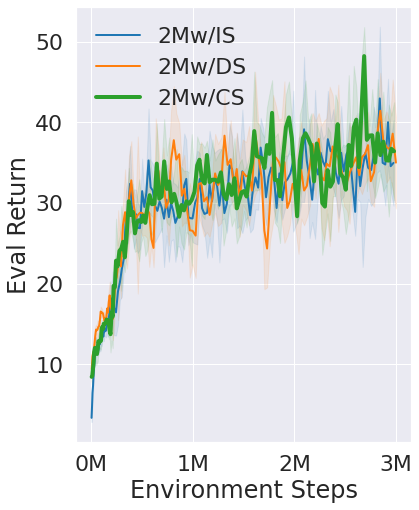

In [125]:
legend = ['2Mw/IS', '2Mw/DS', '2Mw/CS']
color = ['tab:blue', 'tab:orange', 'tab:green']
shape = ['solid', 'solid', 'solid', 'solid']
linewidth = [2, 2, 4]
plot_group(group, legend, color, shape, linewidth, font_scale=2, weight=0.5, x_label='Environment Steps', y_label='Eval Return', title='', in_legend=True)

#### Asterix

In [138]:
api = wandb.Api()
entity, project = "zhao666", "2MMinAtarAllResults"  # set to your entity and project 
group = []

In [140]:
filters = {
            "config.env_name": 'MinAtar/Asterix-v1',
            "config.ec_factor_start": 0.1,
            "config.ec_factor_end": 0.9,
            "config.RL_train_freq": 10,
            "config.mfec_k": 3,
            "config.data_sharing": False
}
runs = api.runs(entity + "/" + project, filters=filters, per_page=300) 
print('Configs: {} \nTotal runs: {}'.format(runs.filters, runs.length))

Configs: {'config.env_name': 'MinAtar/Asterix-v1', 'config.ec_factor_start': 0.1, 'config.ec_factor_end': 0.9, 'config.RL_train_freq': 10, 'config.mfec_k': 3, 'config.data_sharing': False} 
Total runs: 5


In [141]:
group.append(runs)

In [143]:
filters = {
            "config.env_name": 'MinAtar/Asterix-v1',
            "config.ec_factor_start": 0.9,
            "config.ec_factor_end": 0.1,
            "config.RL_train_freq": 10,
            "config.mfec_k": 3,
            "config.data_sharing": False
}
runs = api.runs(entity + "/" + project, filters=filters, per_page=300) 
print('Configs: {} \nTotal runs: {}'.format(runs.filters, runs.length))

Configs: {'config.env_name': 'MinAtar/Asterix-v1', 'config.ec_factor_start': 0.9, 'config.ec_factor_end': 0.1, 'config.RL_train_freq': 10, 'config.mfec_k': 3, 'config.data_sharing': False} 
Total runs: 5


In [144]:
group.append(runs)

In [146]:
filters = {
            "config.env_name": 'MinAtar/Asterix-v1',
            "config.ec_factor_start": 0.5,
            "config.ec_factor_end": 0.5,
            "config.RL_train_freq": 10,
            "config.mfec_k": 3,
            "config.data_sharing": False
}
runs = api.runs(entity + "/" + project, filters=filters, per_page=300) 
print('Configs: {} \nTotal runs: {}'.format(runs.filters, runs.length))

Configs: {'config.env_name': 'MinAtar/Asterix-v1', 'config.ec_factor_start': 0.5, 'config.ec_factor_end': 0.5, 'config.RL_train_freq': 10, 'config.mfec_k': 3, 'config.data_sharing': False} 
Total runs: 5


In [147]:
group.append(runs)

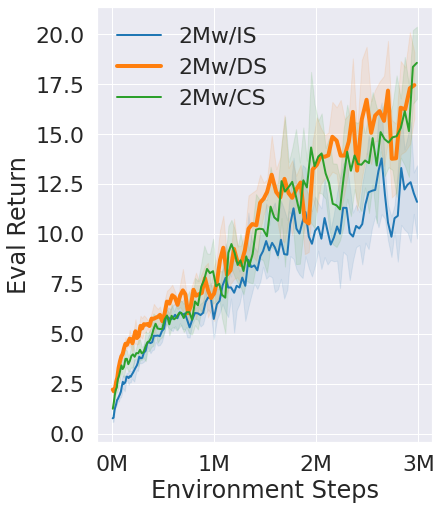

In [149]:
legend = ['2Mw/IS', '2Mw/DS', '2Mw/CS']
color = ['tab:blue', 'tab:orange', 'tab:green']
shape = ['solid', 'solid', 'solid', 'solid']
linewidth = [2, 4, 2]
plot_group(group, legend, color, shape, linewidth, font_scale=2, weight=0.5, x_label='Environment Steps', y_label='Eval Return', title='', in_legend=True)

#### Seaquest

In [150]:
api = wandb.Api()
entity, project = "zhao666", "2MMinAtarAllResults"  # set to your entity and project 
group = []

In [152]:
filters = {
            "config.env_name": 'MinAtar/Seaquest-v1',
            "config.ec_factor_start": 0.1,
            "config.ec_factor_end": 0.9,
            "config.RL_train_freq": 10,
            "config.mfec_k": 3,
            "config.data_sharing": False
}
runs = api.runs(entity + "/" + project, filters=filters, per_page=300) 
print('Configs: {} \nTotal runs: {}'.format(runs.filters, runs.length))

Configs: {'config.env_name': 'MinAtar/Seaquest-v1', 'config.ec_factor_start': 0.1, 'config.ec_factor_end': 0.9, 'config.RL_train_freq': 10, 'config.mfec_k': 3, 'config.data_sharing': False} 
Total runs: 5


In [153]:
group.append(runs)

In [155]:
filters = {
            "config.env_name": 'MinAtar/Seaquest-v1',
            "config.ec_factor_start": 0.9,
            "config.ec_factor_end": 0.1,
            "config.RL_train_freq": 10,
            "config.mfec_k": 3,
            "config.data_sharing": False
}
runs = api.runs(entity + "/" + project, filters=filters, per_page=300) 
print('Configs: {} \nTotal runs: {}'.format(runs.filters, runs.length))

Configs: {'config.env_name': 'MinAtar/Seaquest-v1', 'config.ec_factor_start': 0.9, 'config.ec_factor_end': 0.1, 'config.RL_train_freq': 10, 'config.mfec_k': 3, 'config.data_sharing': False} 
Total runs: 5


In [156]:
group.append(runs)

In [158]:
filters = {
            "config.env_name": 'MinAtar/Seaquest-v1',
            "config.ec_factor_start": 0.5,
            "config.ec_factor_end": 0.5,
            "config.RL_train_freq": 10,
            "config.mfec_k": 3,
            "config.data_sharing": False
}
runs = api.runs(entity + "/" + project, filters=filters, per_page=300) 
print('Configs: {} \nTotal runs: {}'.format(runs.filters, runs.length))

Configs: {'config.env_name': 'MinAtar/Seaquest-v1', 'config.ec_factor_start': 0.5, 'config.ec_factor_end': 0.5, 'config.RL_train_freq': 10, 'config.mfec_k': 3, 'config.data_sharing': False} 
Total runs: 5


In [159]:
group.append(runs)

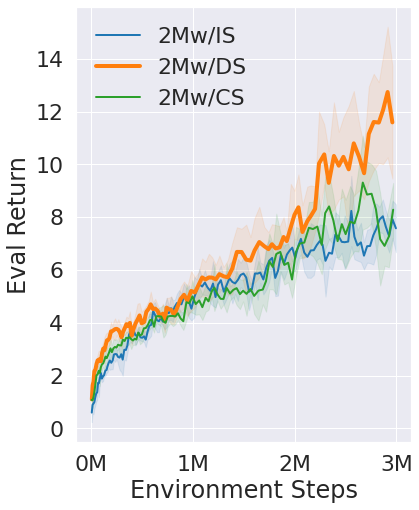

In [160]:
legend = ['2Mw/IS', '2Mw/DS', '2Mw/CS']
color = ['tab:blue', 'tab:orange', 'tab:green']
shape = ['solid', 'solid', 'solid', 'solid']
linewidth = [2, 4, 2]
plot_group(group, legend, color, shape, linewidth, font_scale=2, weight=0.5, x_label='Environment Steps', y_label='Eval Return', title='', in_legend=True)

#### Freeway

In [195]:
api = wandb.Api()
entity, project = "zhao666", "2MMinAtarAllResults"  # set to your entity and project 
group = []

In [197]:
filters = {
            "config.env_name": 'MinAtar/Freeway-v1',
            "config.ec_factor_start": 0.1,
            "config.ec_factor_end": 0.9,
            "config.RL_train_freq": 10,
            "config.mfec_k": 3,
            "config.data_sharing": False
}
runs = api.runs(entity + "/" + project, filters=filters, per_page=300) 
print('Configs: {} \nTotal runs: {}'.format(runs.filters, runs.length))

Configs: {'config.env_name': 'MinAtar/Freeway-v1', 'config.ec_factor_start': 0.1, 'config.ec_factor_end': 0.9, 'config.RL_train_freq': 10, 'config.mfec_k': 3, 'config.data_sharing': False} 
Total runs: 5


In [198]:
group.append(runs)

In [200]:
filters = {
            "config.env_name": 'MinAtar/Freeway-v1',
            "config.ec_factor_start": 0.5,
            "config.ec_factor_end": 0.1,
            "config.RL_train_freq": 10,
            "config.mfec_k": 3,
            "config.data_sharing": False
}
runs = api.runs(entity + "/" + project, filters=filters, per_page=300) 
print('Configs: {} \nTotal runs: {}'.format(runs.filters, runs.length))

Configs: {'config.env_name': 'MinAtar/Freeway-v1', 'config.ec_factor_start': 0.5, 'config.ec_factor_end': 0.1, 'config.RL_train_freq': 10, 'config.mfec_k': 3, 'config.data_sharing': False} 
Total runs: 5


In [201]:
group.append(runs)

In [203]:
filters = {
            "config.env_name": 'MinAtar/Freeway-v1',
            "config.ec_factor_start": 0.5,
            "config.ec_factor_end": 0.5,
            "config.RL_train_freq": 10,
            "config.mfec_k": 3,
            "config.data_sharing": False
}
runs = api.runs(entity + "/" + project, filters=filters, per_page=300) 
print('Configs: {} \nTotal runs: {}'.format(runs.filters, runs.length))

Configs: {'config.env_name': 'MinAtar/Freeway-v1', 'config.ec_factor_start': 0.5, 'config.ec_factor_end': 0.5, 'config.RL_train_freq': 10, 'config.mfec_k': 3, 'config.data_sharing': False} 
Total runs: 5


In [204]:
group.append(runs)

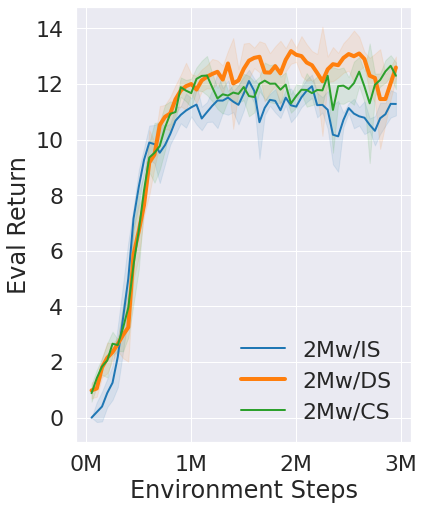

In [205]:
legend = ['2Mw/IS', '2Mw/DS', '2Mw/CS']
color = ['tab:blue', 'tab:orange', 'tab:green']
shape = ['solid', 'solid', 'solid', 'solid']
linewidth = [2, 4, 2]
plot_group(group, legend, color, shape, linewidth, font_scale=2, weight=0.5, x_label='Environment Steps', y_label='Eval Return', title='', in_legend=True)

### Ablation study: on data sharing

#### Breakout

In [15]:
api = wandb.Api()
entity, project = "zhao666", "2MMinAtarAllResults"  # set to your entity and project 
group = []

In [18]:
filters = {
            "config.env_name": 'MinAtar/Breakout-v1',
            "config.ec_factor_start": 0.5,
            #"config.ec_factor_end": 0.1,
            "config.RL_train_freq": 10,
            "config.mfec_k": 3,
            "config.data_sharing": True
}
runs = api.runs(entity + "/" + project, filters=filters, per_page=300) 
print('Configs: {} \nTotal runs: {}'.format(runs.filters, runs.length))

Configs: {'config.env_name': 'MinAtar/Breakout-v1', 'config.ec_factor_start': 0.5, 'config.RL_train_freq': 10, 'config.mfec_k': 3, 'config.data_sharing': True} 
Total runs: 15


In [19]:
group.append(runs)

In [21]:
filters = {
            "config.env_name": 'MinAtar/Breakout-v1',
            "config.ec_factor_start": 0.5,
            #"config.ec_factor_end": 0.1,
            "config.RL_train_freq": 10,
            "config.mfec_k": 3,
            "config.data_sharing": False
}
runs = api.runs(entity + "/" + project, filters=filters, per_page=300) 
print('Configs: {} \nTotal runs: {}'.format(runs.filters, runs.length))

Configs: {'config.env_name': 'MinAtar/Breakout-v1', 'config.ec_factor_start': 0.5, 'config.RL_train_freq': 10, 'config.mfec_k': 3, 'config.data_sharing': False} 
Total runs: 15


In [22]:
group.append(runs)

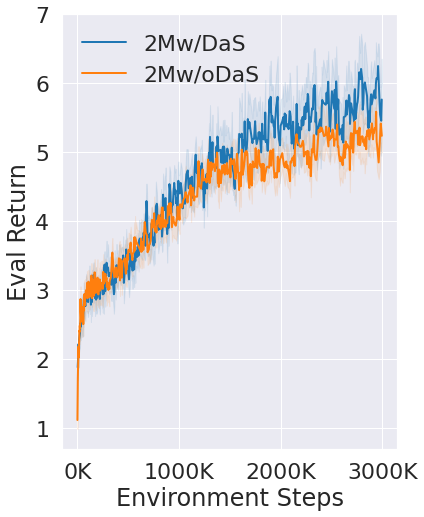

In [23]:
legend = ['2Mw/DaS', '2Mw/oDaS']
color = ['tab:blue', 'tab:orange']
shape = ['solid', 'solid', 'solid', 'solid']
linewidth = [2, 2, 4]
plot_group(group, legend, color, shape, linewidth, font_scale=2, weight=0.5, x_label='Environment Steps', y_label='Eval Return', title='', in_legend=True)

#### Seaquest

In [24]:
api = wandb.Api()
entity, project = "zhao666", "2MMinAtarAllResults"  # set to your entity and project 
group = []

In [26]:
filters = {
            "config.env_name": 'MinAtar/Seaquest-v1',
            "config.ec_factor_start": 0.1,
            #"config.ec_factor_end": 0.1,
            "config.RL_train_freq": 10,
            "config.mfec_k": 3,
            "config.data_sharing": True
}
runs = api.runs(entity + "/" + project, filters=filters, per_page=300) 
print('Configs: {} \nTotal runs: {}'.format(runs.filters, runs.length))

Configs: {'config.env_name': 'MinAtar/Seaquest-v1', 'config.ec_factor_start': 0.1, 'config.RL_train_freq': 10, 'config.mfec_k': 3, 'config.data_sharing': True} 
Total runs: 10


In [27]:
group.append(runs)

In [29]:
filters = {
            "config.env_name": 'MinAtar/Seaquest-v1',
            "config.ec_factor_start": 0.1,
            #"config.ec_factor_end": 0.1,
            "config.RL_train_freq": 10,
            "config.mfec_k": 3,
            "config.data_sharing": False
}
runs = api.runs(entity + "/" + project, filters=filters, per_page=300) 
print('Configs: {} \nTotal runs: {}'.format(runs.filters, runs.length))

Configs: {'config.env_name': 'MinAtar/Seaquest-v1', 'config.ec_factor_start': 0.1, 'config.RL_train_freq': 10, 'config.mfec_k': 3, 'config.data_sharing': False} 
Total runs: 10


In [30]:
group.append(runs)

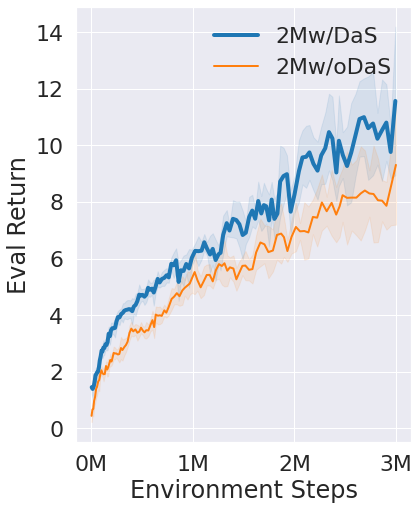

In [35]:
legend = ['2Mw/DaS', '2Mw/oDaS']
color = ['tab:blue', 'tab:orange']
shape = ['solid', 'solid', 'solid', 'solid']
linewidth = [4, 2]
plot_group(group, legend, color, shape, linewidth, font_scale=2, weight=0.5, x_label='Environment Steps', y_label='Eval Return', title='', in_legend=True)

#### Asterix

In [36]:
api = wandb.Api()
entity, project = "zhao666", "2MMinAtarAllResults"  # set to your entity and project 
group = []

In [38]:
filters = {
            "config.env_name": 'MinAtar/Asterix-v1',
            "config.ec_factor_start": 0.5,
            #"config.ec_factor_end": 0.1,
            "config.RL_train_freq": 10,
            "config.mfec_k": 3,
            "config.data_sharing": True
}
runs = api.runs(entity + "/" + project, filters=filters, per_page=300) 
print('Configs: {} \nTotal runs: {}'.format(runs.filters, runs.length))

Configs: {'config.env_name': 'MinAtar/Asterix-v1', 'config.ec_factor_start': 0.5, 'config.RL_train_freq': 10, 'config.mfec_k': 3, 'config.data_sharing': True} 
Total runs: 15


In [39]:
group.append(runs)

In [41]:
filters = {
            "config.env_name": 'MinAtar/Asterix-v1',
            "config.ec_factor_start": 0.5,
            #"config.ec_factor_end": 0.1,
            "config.RL_train_freq": 10,
            "config.mfec_k": 3,
            "config.data_sharing": False
}
runs = api.runs(entity + "/" + project, filters=filters, per_page=300) 
print('Configs: {} \nTotal runs: {}'.format(runs.filters, runs.length))

Configs: {'config.env_name': 'MinAtar/Asterix-v1', 'config.ec_factor_start': 0.5, 'config.RL_train_freq': 10, 'config.mfec_k': 3, 'config.data_sharing': False} 
Total runs: 15


In [42]:
group.append(runs)

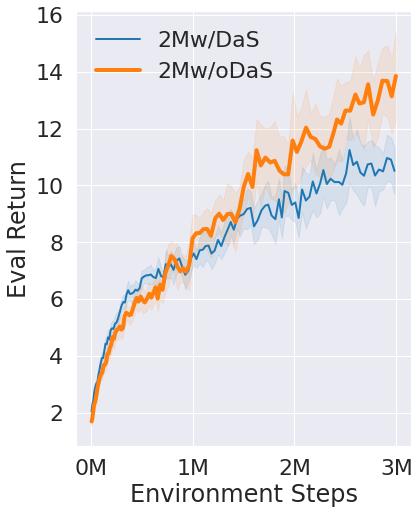

In [43]:
legend = ['2Mw/DaS', '2Mw/oDaS']
color = ['tab:blue', 'tab:orange']
shape = ['solid', 'solid', 'solid', 'solid']
linewidth = [2, 4]
plot_group(group, legend, color, shape, linewidth, font_scale=2, weight=0.5, x_label='Environment Steps', y_label='Eval Return', title='', in_legend=True)

#### SpaceInvaders

In [284]:
api = wandb.Api()
entity, project = "zhao666", "2MMinAtarAllResults"  # set to your entity and project 
group = []

In [286]:
filters = {
            "config.env_name": 'MinAtar/SpaceInvaders-v1',
            "config.ec_factor_start": 0.9,
            "config.ec_factor_end": 0.1,
            "config.RL_train_freq": 10,
            "config.mfec_k": 3,
            "config.data_sharing": True
}
runs = api.runs(entity + "/" + project, filters=filters, per_page=300) 
print('Configs: {} \nTotal runs: {}'.format(runs.filters, runs.length))

Configs: {'config.env_name': 'MinAtar/SpaceInvaders-v1', 'config.ec_factor_start': 0.9, 'config.ec_factor_end': 0.1, 'config.RL_train_freq': 10, 'config.mfec_k': 3, 'config.data_sharing': True} 
Total runs: 5


In [287]:
group.append(runs)

In [289]:
filters = {
            "config.env_name": 'MinAtar/SpaceInvaders-v1',
            "config.ec_factor_start": 0.9,
            "config.ec_factor_end": 0.1,
            "config.RL_train_freq": 10,
            "config.mfec_k": 3,
            "config.data_sharing": False
}
runs = api.runs(entity + "/" + project, filters=filters, per_page=300) 
print('Configs: {} \nTotal runs: {}'.format(runs.filters, runs.length))

Configs: {'config.env_name': 'MinAtar/SpaceInvaders-v1', 'config.ec_factor_start': 0.9, 'config.ec_factor_end': 0.1, 'config.RL_train_freq': 10, 'config.mfec_k': 3, 'config.data_sharing': False} 
Total runs: 5


In [290]:
group.append(runs)

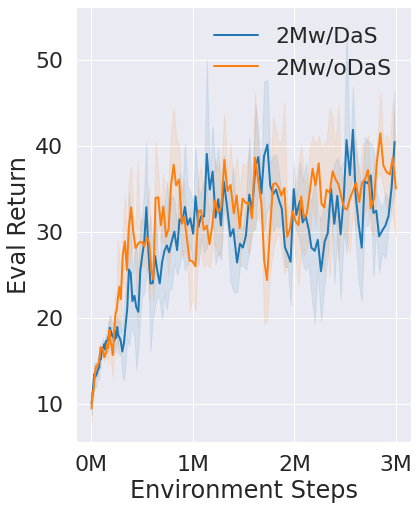

In [292]:
legend = ['2Mw/DaS', '2Mw/oDaS']
color = ['tab:blue', 'tab:orange']
shape = ['solid', 'solid', 'solid', 'solid']
linewidth = [2, 2]
plot_group(group, legend, color, shape, linewidth, font_scale=2, weight=0.5, x_label='Environment Steps', y_label='Eval Return', title='', in_legend=True)

#### Freeway

In [296]:
api = wandb.Api()
entity, project = "zhao666", "2MMinAtarAllResults"  # set to your entity and project 
group = []

In [298]:
filters = {
            "config.env_name": 'MinAtar/Freeway-v1',
            "config.ec_factor_start": 0.5,
            "config.ec_factor_end": 0.1,
            "config.RL_train_freq": 10,
            "config.mfec_k": 3,
            "config.data_sharing": True
}
runs = api.runs(entity + "/" + project, filters=filters, per_page=300) 
print('Configs: {} \nTotal runs: {}'.format(runs.filters, runs.length))

Configs: {'config.env_name': 'MinAtar/Freeway-v1', 'config.ec_factor_start': 0.5, 'config.ec_factor_end': 0.1, 'config.RL_train_freq': 10, 'config.mfec_k': 3, 'config.data_sharing': True} 
Total runs: 5


In [299]:
group.append(runs)

In [301]:
filters = {
            "config.env_name": 'MinAtar/Freeway-v1',
            "config.ec_factor_start": 0.5,
            "config.ec_factor_end": 0.1,
            "config.RL_train_freq": 10,
            "config.mfec_k": 3,
            "config.data_sharing": False
}
runs = api.runs(entity + "/" + project, filters=filters, per_page=300) 
print('Configs: {} \nTotal runs: {}'.format(runs.filters, runs.length))

Configs: {'config.env_name': 'MinAtar/Freeway-v1', 'config.ec_factor_start': 0.5, 'config.ec_factor_end': 0.1, 'config.RL_train_freq': 10, 'config.mfec_k': 3, 'config.data_sharing': False} 
Total runs: 5


In [302]:
group.append(runs)

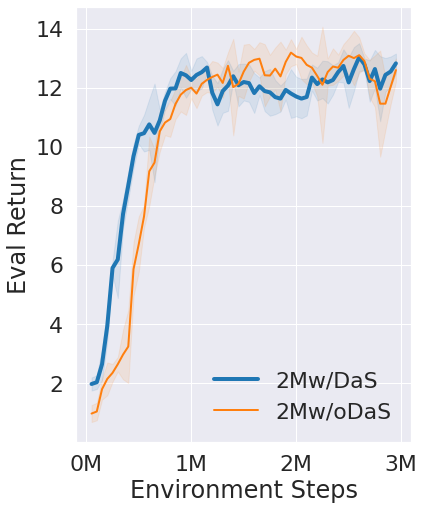

In [303]:
legend = ['2Mw/DaS', '2Mw/oDaS']
color = ['tab:blue', 'tab:orange']
shape = ['solid', 'solid', 'solid', 'solid']
linewidth = [4, 2]
plot_group(group, legend, color, shape, linewidth, font_scale=2, weight=0.5, x_label='Environment Steps', y_label='Eval Return', title='', in_legend=True)